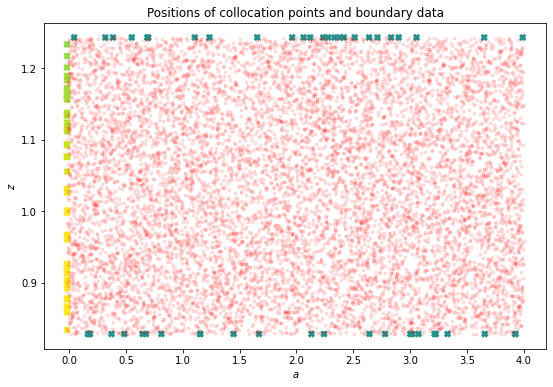

In [135]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Parameter
gamma = 0.5
r = 0.03
rho = 0.05
Var = 0.07
Corr = 0.9
the = -np.log(Corr)
sig2 = 2*the*Var
cap_u = 1e-3
cap_c = 1e-3

# Set constants
gamma = tf.constant(gamma, dtype=DTYPE)
r = tf.constant(r, dtype=DTYPE)
rho = tf.constant(rho, dtype=DTYPE)
# zmean = tf.constant(zmean, dtype=DTYPE)
the = tf.constant(the, dtype=DTYPE)
sig2 = tf.constant(sig2, dtype=DTYPE)

cap_u = tf.Variable(cap_u, dtype=DTYPE)
cap_c = tf.Variable(cap_c, dtype=DTYPE)

# utility function
# @tf.function


def u(c):
    return c**(1-gamma)/(1-gamma)


# @tf.function
def u_deriv_inv(c):
    return c**(-1/gamma)


# Define initial condition
# def fun_u_0(x):
#     return -tf.sin(pi * x)

# Define boundary condition
def fun_v_b_a(a, z):
    return u_deriv_inv(z+r*a)


def fun_v_b_z(a, z):
    n = z.shape[0]
    return tf.zeros((n, 1), dtype=DTYPE)

# Define residual of the PDE


def fun_r0(v_z):
    n = v_z.shape[0]
    return v_z - tf.zeros((n, 1), dtype=DTYPE)

def fun_r(a, z, v, v_a, v_z, v_zz):
    length = a.shape[0]

    # v_a = tf.where(v_a <= cap, cap*tf.ones((length, 1),
    #              dtype=DTYPE), v_a)

    c = tf.where(v_a <= 0, cap_c*tf.ones((length, 1),
                                         dtype=DTYPE), u_deriv_inv(v_a))
    u_c = u(c)
    # tf.print(tf.math.reduce_max(u_deriv_inv(v_a)), tf.math.reduce_max(
    #     v_a), tf.math.reduce_max(v_z), tf.math.reduce_max(v_zz))
    return -rho*v+u_c+v_a*(z+r*a-c)+(-the*tf.math.log(z)+sig2/2)*v_z + sig2*z**2/2*v_zz


# Set number of data points
N_b = 50
N_r = 10000

# Set boundary
zmean = np.exp(Var/2)

amin = -0.02
amax = 4
zmin = zmean*0.8
zmax = zmean*1.2


# Lower bounds
lb = tf.constant([amin, zmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([amax, zmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# # Draw uniform sample points for initial boundary data
# t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
# x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
# X_0 = tf.concat([t_0, x_0], axis=1)

# # Evaluate intitial condition at x_0
# u_0 = fun_u_0(x_0)

# Boundary data
# a_b_a = lb[0] + (ub[0] - lb[0]) * \
#     tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)
# z_b_a = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype=DTYPE)

# X_b_a = tf.concat([a_b_a, z_b_a], axis=1)

# # Evaluate boundary condition at (t_b,x_b)
# u_b_a = fun_v_b_a(a_b_a, z_b_a)

a_b_z = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
z_b_z = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype=DTYPE)
X_b_z = tf.concat([a_b_z, z_b_z], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b_z = fun_v_b_z(a_b_z, z_b_z)


# Draw uniformly sampled collocation points
a_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
z_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([a_r, z_r], axis=1)

# Collect boundary and inital data in lists
# X_data = [X_b_a, X_b_z]
# u_data = [u_b_a, u_b_z]

X_data = X_b_z
u_data = u_b_z


a_b_a = lb[0] * tf.ones((N_b, 1), dtype=DTYPE)
z_b_a = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype=DTYPE)
X_b_a = tf.concat([a_b_a, z_b_a], axis=1)
u_b_a = fun_v_b_a(a_b_a, z_b_a)

X_data2 = X_b_a
u_data2 = u_b_a


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(a_b_a, z_b_a, c=u_b_a, marker='X', vmin=-1, vmax=1)
plt.scatter(a_b_z, z_b_z, c=u_b_z, marker='X', vmin=-1, vmax=1)
plt.scatter(a_r, z_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$a$')
plt.ylabel('$z$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)


In [149]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    # scaling_layer = tf.keras.layers.Lambda(
    #             lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    # model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
                                        activation=tf.keras.activations.get(
                                            'tanh'),
                                        kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model


def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        a, z = X_r[:, 0:1], X_r[:, 1:2]
        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(a)
        tape.watch(z)

        # Determine residual
        v = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        v_z = tape.gradient(v, z)

    v_a = tape.gradient(v, a)
    # v_a_m = tf.where(v_a <= cap, cap*tf.ones((length,1), dtype=DTYPE), v_a)
    # v_a_m
    v_zz = tape.gradient(v_z, z)

    del tape

    return fun_r(a, z, v, v_a, v_z, v_zz)


def get_r0(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        a, z = X_r[:, 0:1], X_r[:, 1:2]
        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(a)
        tape.watch(z)

        # Determine residual
        v = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        v_z = tape.gradient(v, z)

    del tape

    return fun_r0(v_z)

def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # r0 = get_r0(model, X_r)
    # phi_r0 = tf.reduce_mean(tf.square(r0))

    # Initialize loss
    loss = phi_r
    

    # phi_0 = phi_r-phi_r
    # # Add phi^0 and phi^b to the loss
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        a, z = X_data[:, 0:1], X_data[:, 1:2]
        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(a)
        tape.watch(z)

    #     # Determine residual
        v = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

    #     # Compute gradient u_x within the GradientTape
    #     # since we need second derivatives
        v_z = tape.gradient(v, z)

    del tape
    phi_1 = tf.reduce_mean(tf.square(u_data - v_z))
    
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        a, z = X_data2[:, 0:1], X_data2[:, 1:2]
        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(a)
        tape.watch(z)

    #     # Determine residual
        v = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

    #     # Compute gradient u_x within the GradientTape
    #     # since we need second derivatives
        v_a = tape.gradient(v, a)

    del tape
    phi_2 = tf.reduce_mean(tf.square(u_data2 - v_a))

    state_orig = v_a - u_data2
    opt_punish_state = (1.0/1e-5) * tf.maximum(-1 * state_orig,
                                              tf.zeros_like(state_orig), name='opt_punish_state')

    loss += tf.reduce_mean(tf.square(u_data - v_z))
    loss += tf.reduce_mean(tf.square(opt_punish_state))

    # loss += tf.reduce_mean(tf.square(u_data[i] - v_pred_z))
    
    # ineq = get_ineq(model, X_r)
    # phi_ineq = tf.reduce_mean(tf.square(ineq))
    # tf.print(phi_r, phi_0)
    # loss = phi_r+phi_0
    return loss


def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    # capped_gvs = [(tf.clip_by_value(grad, -2.0, 2.0), var)
    g = tape.gradient(loss, model.trainable_variables)

    del tape

    return loss, g


# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 20000], [1e-2, 1e-3, 1e-4])

# Choose the optimizer

optim = tf.keras.optimizers.Adam(learning_rate=lr)




In [118]:
X_data[:,1]


<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1.2427436 , 1.2427436 , 1.2427436 , 0.82849574, 1.2427436 ,
       0.82849574, 0.82849574, 1.2427436 , 1.2427436 , 0.82849574,
       1.2427436 , 1.2427436 , 0.82849574, 1.2427436 , 0.82849574,
       1.2427436 , 1.2427436 , 0.82849574, 0.82849574, 0.82849574,
       0.82849574, 1.2427436 , 0.82849574, 1.2427436 , 1.2427436 ,
       0.82849574, 1.2427436 , 0.82849574, 1.2427436 , 0.82849574,
       0.82849574, 1.2427436 , 1.2427436 , 0.82849574, 1.2427436 ,
       1.2427436 , 1.2427436 , 1.2427436 , 0.82849574, 0.82849574,
       1.2427436 , 0.82849574, 0.82849574, 1.2427436 , 0.82849574,
       0.82849574, 1.2427436 , 0.82849574, 1.2427436 , 0.82849574],
      dtype=float32)>

In [131]:

i=1
    # u_pred = model(X_data[i])
with tf.GradientTape(persistent=True) as tape:
    # Split t and x to compute partial derivatives
    a, z = X_data[:, 0:1], X_data[:, 1:2]
    # Variables t and x are watched during tape
    # to compute derivatives u_t and u_x
    tape.watch(a)
    tape.watch(z)

#     # Determine residual
    v = model(tf.stack([a[:, 0], z[:, 0]], axis=1))

#     # Compute gradient u_x within the GradientTape
#     # since we need second derivatives
    v_z = tape.gradient(v, z)

# del tape
loss = tf.reduce_mean(tf.square(u_data - v_z))


In [150]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training


@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


# Number of training epochs
N = 30000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i % 50 == 0:
    
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

# # Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


It 00000: loss = 1.10601411e+10
It 00050: loss = 1.43028671e+02
It 00100: loss = 1.51052429e+02
It 00150: loss = 1.50410477e+02


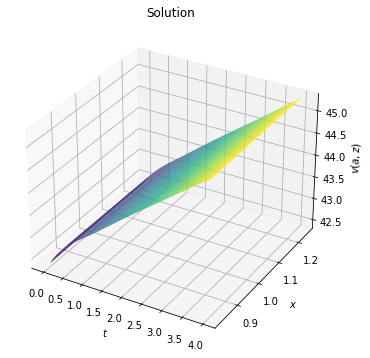

In [147]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T

# # Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid, DTYPE))

# # Reshape upred
U = upred.numpy().reshape(N+1, N+1)

# # Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
# ax.view_init(35, 35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$v(a,z)$')
ax.set_title('Solution')
plt.savefig('HJB_version6.pdf', bbox_inches='tight', dpi=300);


In [144]:
U.max(),U.min()


(45.566593, 42.59302)

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist, 'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
